### Libraries

In [1]:
from scipy.stats import norm, wasserstein_distance
from scipy.spatial.distance import cdist
import kagglehub
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math

### Functions

In [2]:
# Enable copy-on-write mode for pandas DataFrames
pd.set_option("mode.copy_on_write", True)


# Downloads and loads the dataset from Kaggle and returns the CSV path
def download_data():
    path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")
    files = os.listdir(path)
    csv_file = files[0]
    return os.path.join(path, csv_file)


# Reads in the dataset
def load_data(csv_path: str) -> pd.DataFrame:
    return pd.read_csv(csv_path, encoding="ISO-8859-1")

### Data

In [3]:
data_ = load_data(download_data())
print(data_.shape)
data_.head(100000)

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [4]:
df = data_[["default.payment.next.month", "LIMIT_BAL", "ID"]].copy()
df.rename(
    columns={
        "LIMIT_BAL": "CREDIT_LINE",
        "default.payment.next.month": "DEFAULT_STATUS",
    },
    inplace=True,
)
print(df.shape)
df.head()

(30000, 3)


,DEFAULT_STATUS,CREDIT_LINE,ID
0,1,20000.0,1
1,1,120000.0,2
2,0,90000.0,3
3,0,50000.0,4
4,0,50000.0,5


In [5]:
credit_lines = df.CREDIT_LINE.values
credit_lines

array([ 20000., 120000.,  90000., ...,  30000.,  80000.,  50000.],
      shape=(30000,))

### Parameter values

In [6]:
payment_default = [0.05, 0.10, 0.15]
# Calibrate correlation range to five values between 0.03 and 0.06
correlation_factor = np.linspace(0.03, 0.06, 5)
threshold = norm.ppf(payment_default)
N = len(credit_lines)
n_simulations = 10000

### Simulation

In [ ]:
results = []

# Loop over the correlation_factor array
for cf in correlation_factor:
    for pd_rate in payment_default:
        total_amount_losses = np.zeros(n_simulations)
        n_user_default = np.zeros(n_simulations)

        for i in range(n_simulations):
            systematic_factor = np.random.normal(0, 1)  # Economic environment
            idiosyncratic_factor = np.random.normal(0, 1, N)  # Individual factor

            # Vasicek formula for latent variable X with correlation = cf
            X = (np.sqrt(cf) * systematic_factor) + (
                np.sqrt(1 - cf) * idiosyncratic_factor
            )

            flag = (X < norm.ppf(pd_rate)).astype(int)
            n_user_default[i] = np.sum(flag)
            total_amount_losses[i] = np.sum(flag * credit_lines)

        # Calculate VaR and CVaR
        var_90 = np.percentile(total_amount_losses, 90)
        var_95 = np.percentile(total_amount_losses, 95)
        var_99 = np.percentile(total_amount_losses, 99)
        cvar_90 = np.mean(total_amount_losses[total_amount_losses >= var_90])
        cvar_95 = np.mean(total_amount_losses[total_amount_losses >= var_95])
        cvar_99 = np.mean(total_amount_losses[total_amount_losses >= var_99])
        mean_default_rate = np.mean(n_user_default) / N

        results.append(
            {
                "correlation_factor": float(cf),
                "payment_default": float(pd_rate),
                "expected_loss": np.mean(total_amount_losses),
                "mean_default_rate": mean_default_rate,
                "VaR_90": var_90,
                "VaR_95": var_95,
                "VaR_99": var_99,
                "CVaR_90": cvar_90,
                "CVaR_95": cvar_95,
                "CVaR_99": cvar_99,
                "max_loss": np.max(total_amount_losses),
                "min_loss": np.min(total_amount_losses),
                "total_losses": total_amount_losses.copy(),
                "n_user_default": n_user_default.copy(),
            }
        )

    print(
        f"Done: ran {n_simulations} simulations per correlation for {len(results)} correlation values: {np.round(correlation_factor, 4)}"
    )

Done: ran 10000 simulations per correlation for 3 correlation values: [0.03   0.0375 0.045  0.0525 0.06  ]
Done: ran 10000 simulations per correlation for 6 correlation values: [0.03   0.0375 0.045  0.0525 0.06  ]
Done: ran 10000 simulations per correlation for 6 correlation values: [0.03   0.0375 0.045  0.0525 0.06  ]
Done: ran 10000 simulations per correlation for 9 correlation values: [0.03   0.0375 0.045  0.0525 0.06  ]
Done: ran 10000 simulations per correlation for 9 correlation values: [0.03   0.0375 0.045  0.0525 0.06  ]
Done: ran 10000 simulations per correlation for 12 correlation values: [0.03   0.0375 0.045  0.0525 0.06  ]
Done: ran 10000 simulations per correlation for 12 correlation values: [0.03   0.0375 0.045  0.0525 0.06  ]
Done: ran 10000 simulations per correlation for 15 correlation values: [0.03   0.0375 0.045  0.0525 0.06  ]
Done: ran 10000 simulations per correlation for 15 correlation values: [0.03   0.0375 0.045  0.0525 0.06  ]


### Results Summary

In [8]:
# Print summary for each scenario
for res in results:
    print(f"Default Rate: {res['payment_default']:.1%}")
    print(f"Correlation: {res['correlation_factor']:.1%}")
    print(f"Mean default rate: {res['mean_default_rate']:.2%}")
    print(f"Expected Loss: NT${res['expected_loss']:,.2f}")
    print(f"VaR 95%: NT${res['VaR_95']:,.2f}")
    print(f"CVaR 95%: NT${res['CVaR_95']:,.2f}")
    print("-" * 40)

Default Rate: 5.0%
Correlation: 3.0%
Mean default rate: 5.01%
Expected Loss: NT$251,618,955.61
VaR 95%: NT$423,573,800.00
CVaR 95%: NT$487,892,267.20
----------------------------------------
Default Rate: 10.0%
Correlation: 3.0%
Mean default rate: 9.99%
Expected Loss: NT$501,961,924.31
VaR 95%: NT$782,680,500.00
CVaR 95%: NT$878,446,613.60
----------------------------------------
Default Rate: 15.0%
Correlation: 3.0%
Mean default rate: 14.96%
Expected Loss: NT$751,731,907.30
VaR 95%: NT$1,122,834,200.00
CVaR 95%: NT$1,237,472,526.40
----------------------------------------
Default Rate: 5.0%
Correlation: 3.8%
Mean default rate: 5.02%
Expected Loss: NT$252,266,414.73
VaR 95%: NT$443,702,000.00
CVaR 95%: NT$512,842,975.04
----------------------------------------
Default Rate: 10.0%
Correlation: 3.8%
Mean default rate: 9.99%
Expected Loss: NT$502,077,450.14
VaR 95%: NT$814,206,700.00
CVaR 95%: NT$923,835,806.56
----------------------------------------
Default Rate: 15.0%
Correlation: 3.8%

In [9]:
print("\n" + "=" * 60)
print("SUMMARY STATISTICS - SIMULATION RESULTS")
print("=" * 60)

print("SIMULATION PARAMETERS:")
print(f"   • Number of simulations per correlation: {n_simulations:,}")
print(f"   • Portfolio size: {N:,} clients")
print(f"   • Probability of Default (PD): {[f'{pd:.2%}' for pd in payment_default]}")
print(f"   • Correlation(s): {[f'{cf:.4f}' for cf in correlation_factor]}")

print(f"\nLOSS STATISTICS (per scenario):")
for res in results:
    print("-" * 40)
    print(f"Correlation (rho): {res['correlation_factor']:.4f}")
    print(f"   • PD: {res['payment_default']:.2%}")
    print(f"   • Expected Loss: NT${res['expected_loss']:,.2f}")
    print(f"   • Minimum Loss: NT${np.min(res['total_losses']):,.2f}")
    print(f"   • Maximum Loss: NT${np.max(res['total_losses']):,.2f}")
    print(f"   • Loss Std Dev: NT${np.std(res['total_losses']):,.2f}")
    print(f"   • VaR 90%: NT${res['VaR_90']:,.2f}")
    print(f"   • VaR 95%: NT${res['VaR_95']:,.2f}")
    print(f"   • VaR 99%: NT${res['VaR_99']:,.2f}")
    print(f"   • CVaR 90%: NT${res['CVaR_90']:,.2f}")
    print(f"   • CVaR 95%: NT${res['CVaR_95']:,.2f}")
    print(f"   • CVaR 99%: NT${res['CVaR_99']:,.2f}")

print("=" * 60)


SUMMARY STATISTICS - SIMULATION RESULTS
SIMULATION PARAMETERS:
   • Number of simulations per correlation: 10,000
   • Portfolio size: 30,000 clients
   • Probability of Default (PD): ['5.00%', '10.00%', '15.00%']
   • Correlation(s): ['0.0300', '0.0375', '0.0450', '0.0525', '0.0600']

LOSS STATISTICS (per scenario):
----------------------------------------
Correlation (rho): 0.0300
   • PD: 5.00%
   • Expected Loss: NT$251,618,955.61
   • Minimum Loss: NT$52,850,000.00
   • Maximum Loss: NT$795,716,000.00
   • Loss Std Dev: NT$92,659,103.98
   • VaR 90%: NT$375,122,400.00
   • VaR 95%: NT$423,573,800.00
   • VaR 99%: NT$525,691,203.20
   • CVaR 90%: NT$442,534,060.40
   • CVaR 95%: NT$487,892,267.20
   • CVaR 99%: NT$580,313,815.20
----------------------------------------
Correlation (rho): 0.0300
   • PD: 10.00%
   • Expected Loss: NT$501,961,924.31
   • Minimum Loss: NT$105,480,000.00
   • Maximum Loss: NT$1,268,060,000.00
   • Loss Std Dev: NT$155,600,140.56
   • VaR 90%: NT$713,0

### Visualizations

#### Distribution Analysis

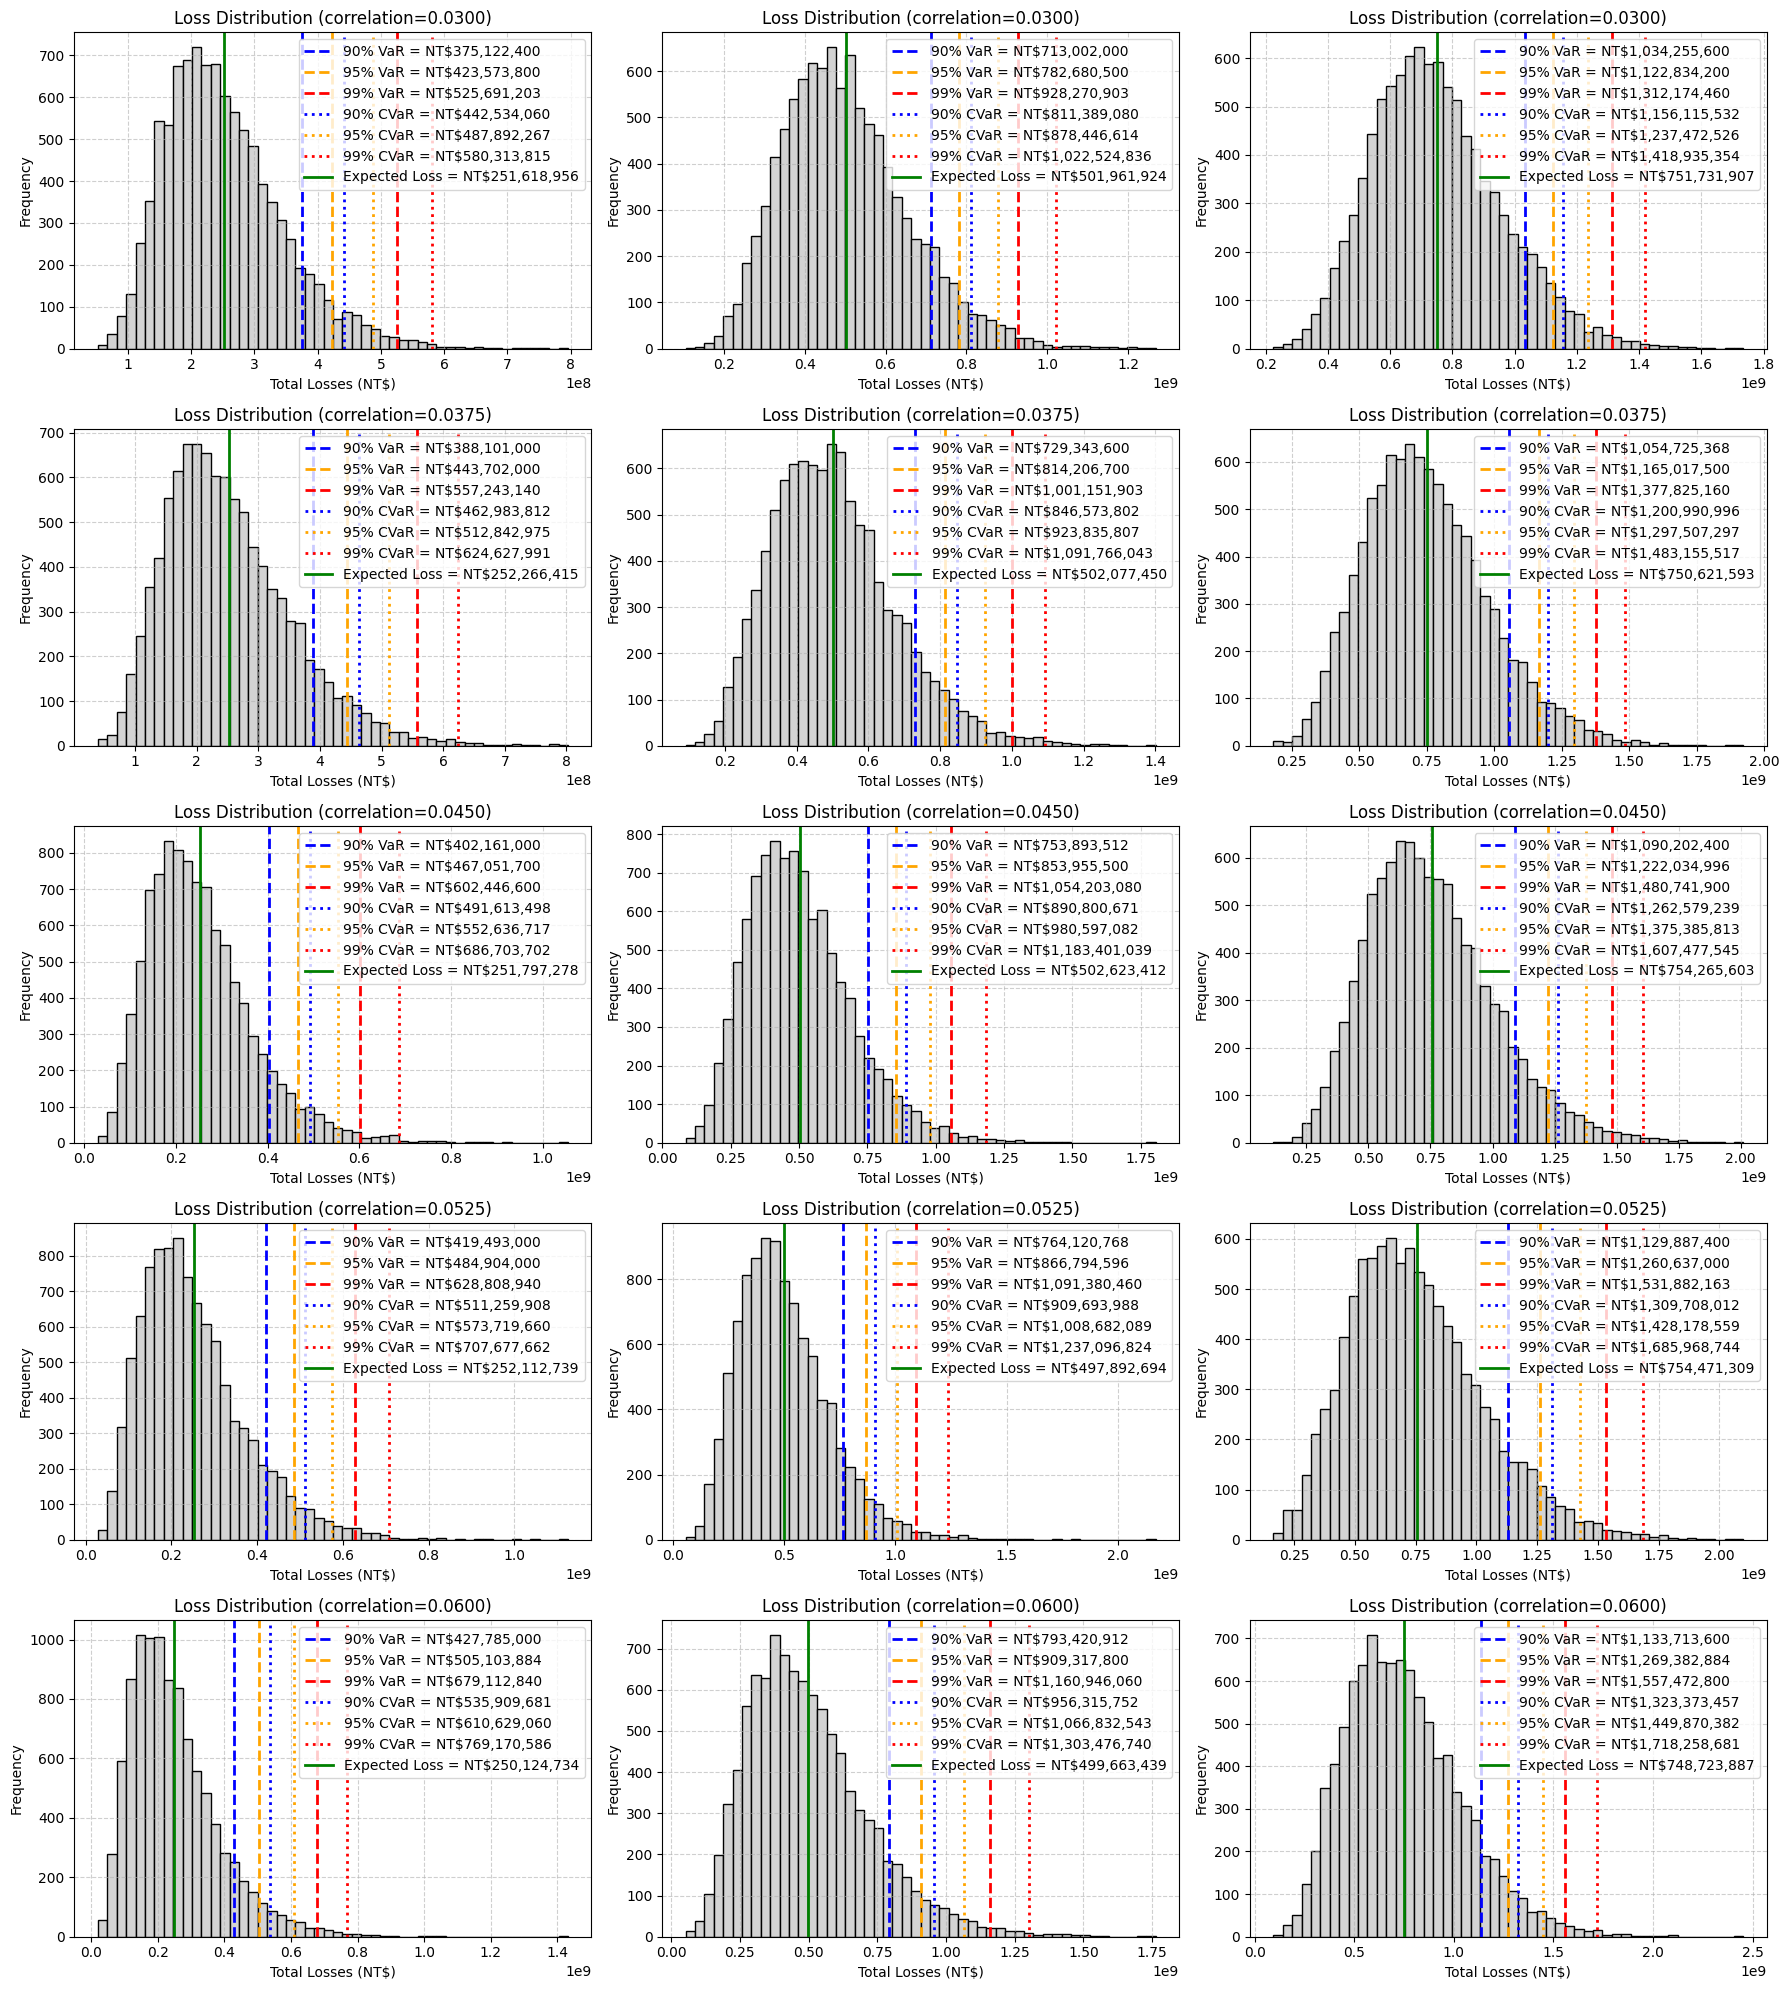

In [10]:
# Plot histogram of total losses for each correlation value in subplots
n = len(results)
cols = 3
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = np.array(axes).reshape(-1)  # flatten

for idx, res in enumerate(results):
    ax = axes[idx]
    total_amount_losses = res["total_losses"]
    cf = res["correlation_factor"]

    ax.hist(total_amount_losses, bins=50, color="lightgray", edgecolor="black")
    ax.set_title(f"Loss Distribution (correlation={cf:.4f})")
    ax.set_xlabel("Total Losses (NT$)")
    ax.set_ylabel("Frequency")

    # VaR and CVaR lines
    ax.axvline(
        res["VaR_90"],
        color="blue",
        linestyle="--",
        linewidth=2,
        label=f'90% VaR = NT${res["VaR_90"]:,.0f}',
    )
    ax.axvline(
        res["VaR_95"],
        color="orange",
        linestyle="--",
        linewidth=2,
        label=f'95% VaR = NT${res["VaR_95"]:,.0f}',
    )
    ax.axvline(
        res["VaR_99"],
        color="red",
        linestyle="--",
        linewidth=2,
        label=f'99% VaR = NT${res["VaR_99"]:,.0f}',
    )

    ax.axvline(
        res["CVaR_90"],
        color="blue",
        linestyle=":",
        linewidth=2,
        label=f'90% CVaR = NT${res["CVaR_90"]:,.0f}',
    )
    ax.axvline(
        res["CVaR_95"],
        color="orange",
        linestyle=":",
        linewidth=2,
        label=f'95% CVaR = NT${res["CVaR_95"]:,.0f}',
    )
    ax.axvline(
        res["CVaR_99"],
        color="red",
        linestyle=":",
        linewidth=2,
        label=f'99% CVaR = NT${res["CVaR_99"]:,.0f}',
    )

    ax.axvline(
        res["expected_loss"],
        color="green",
        linestyle="-",
        linewidth=2,
        label=f'Expected Loss = NT${res["expected_loss"]:,.0f}',
    )
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)

# Turn off any unused subplot axes
for j in range(n, rows * cols):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

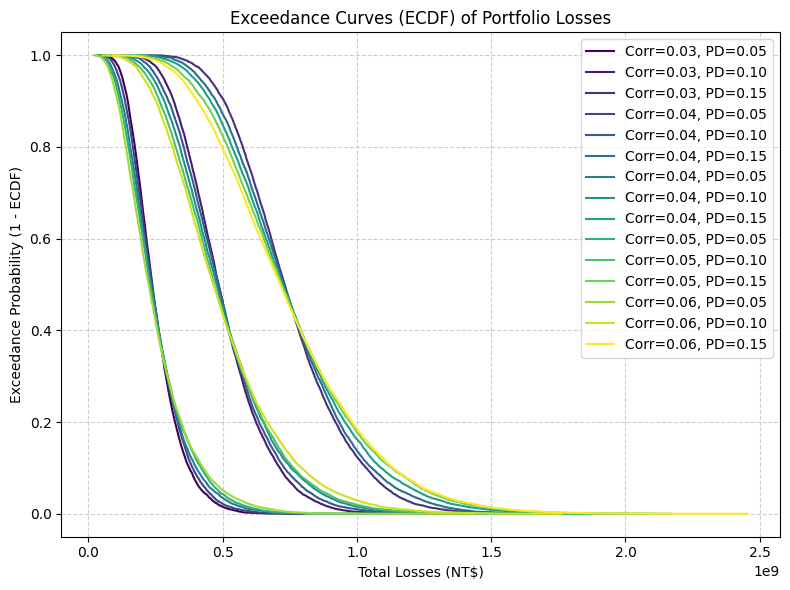

In [11]:
# Plot ECDF (Exceedance curves) for each scenario
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

for idx, res in enumerate(results):
    losses = np.sort(res["total_losses"])
    exceedance = 1.0 - np.arange(1, len(losses) + 1) / len(losses)
    label = f"Corr={res['correlation_factor']:.2f}, PD={res['payment_default']:.2f}"
    plt.plot(losses, exceedance, label=label, color=colors[idx])

plt.xlabel("Total Losses (NT$)")
plt.ylabel("Exceedance Probability (1 - ECDF)")
plt.title("Exceedance Curves (ECDF) of Portfolio Losses")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#### Risk Metrics Analysis

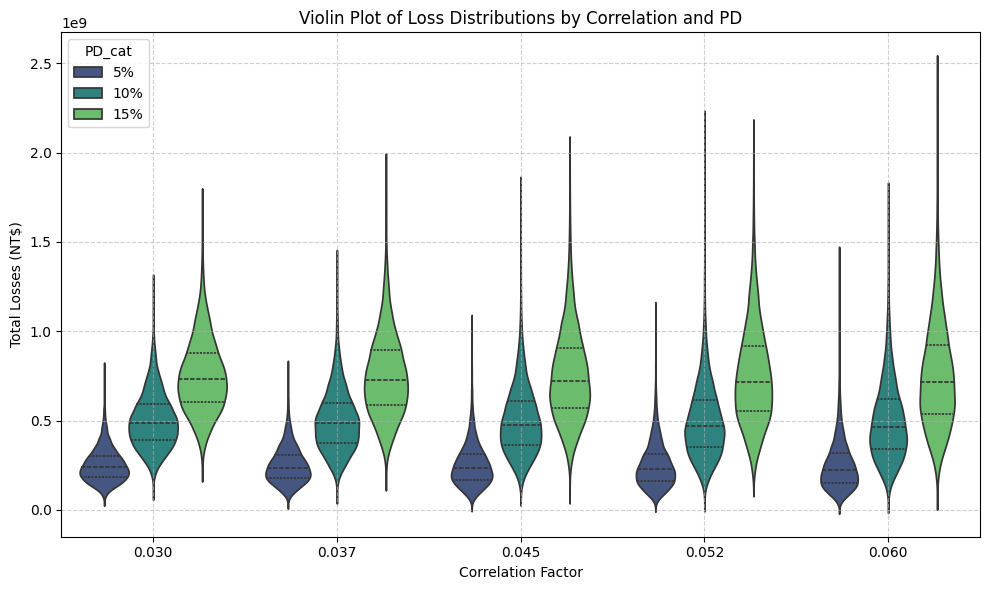

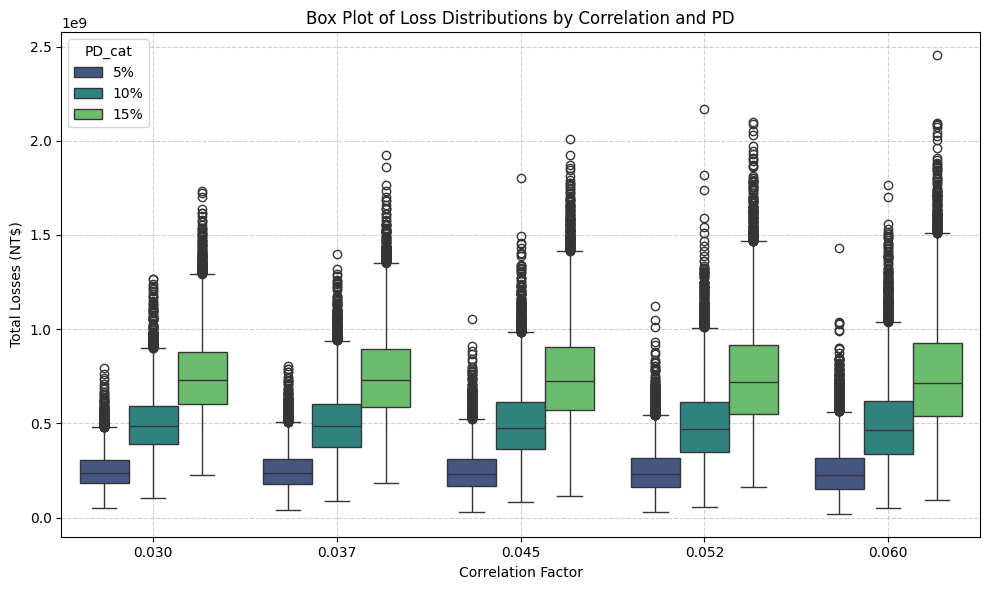

In [17]:
# Compact distribution summaries: violin/box
import pandas as pd
import seaborn as sns

all_losses = []
for res in results:
    for loss in res["total_losses"]:
        all_losses.append(
            {
                "correlation": float(res["correlation_factor"]),
                "PD": float(res["payment_default"]),
                "loss": float(loss),
            }
        )
df_losses = pd.DataFrame(all_losses)

# Make PD and correlation categorical for clearer seaborn grouping/legends
pd_levels = sorted(df_losses["PD"].unique())
pd_labels = [f"{int(round(p*100))}%" for p in pd_levels]
pd_map = dict(zip(pd_levels, pd_labels))
df_losses["PD_cat"] = df_losses["PD"].map(pd_map)

corr_levels = sorted(df_losses["correlation"].unique())
corr_labels = [f"{c:.3f}" for c in corr_levels]
corr_map = dict(zip(corr_levels, corr_labels))
df_losses["corr_cat"] = df_losses["correlation"].map(corr_map)

# Cast to categorical with explicit order to avoid seaborn misinterpretation
df_losses["PD_cat"] = pd.Categorical(
    df_losses["PD_cat"], categories=pd_labels, ordered=True
)
df_losses["corr_cat"] = pd.Categorical(
    df_losses["corr_cat"], categories=corr_labels, ordered=True
)

plt.figure(figsize=(10, 6))
sns.violinplot(
    x="corr_cat",
    y="loss",
    hue="PD_cat",
    data=df_losses,
    inner="quartile",
    palette="viridis",
    dodge=True,
)
plt.title("Violin Plot of Loss Distributions by Correlation and PD")
plt.ylabel("Total Losses (NT$)")
plt.xlabel("Correlation Factor")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x="corr_cat", y="loss", hue="PD_cat", data=df_losses, palette="viridis")
plt.title("Box Plot of Loss Distributions by Correlation and PD")
plt.ylabel("Total Losses (NT$)")
plt.xlabel("Correlation Factor")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()